# Simulation of the Bernstein–Vazirani algorithm on Quobly's hardware using SpinPulse

The Bernstein–Vazirani (BV) algorithm finds a secret bitstring $s\in\{0, 1\}^n$, knowing the function $f(x)=x\cdot s$ where $\cdot$ denotes the bit-wise dot-product and $x\in\{0, 1\}^n$. Assuming we have a black-box oracle computing $f$, the algorithm finds $s$ in one call to oracle, again $n$ calls for a classical algorithm. 

In the following, we will simulate using QiskitAer and the noise model of Quobly's hardware. This noise model is implemented using our library SpinPulse.

In [ ]:
%load_ext autoreload
%autoreload 2
# Necessary imports
import copy

from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator

from spin_pulse import ExperimentalEnvironment, HardwareSpecs, PulseCircuit, Shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by generating a Qiskit circuit implementing the BV algorithm. We use the hidden string to implement the oracle and neglect the consecutive Hadamard gates ($H^2=\mathbb{1}$). This is clearly a toy example, as we use the hidden string to build the circuit. However, this allows us to measure the impact of noise on the result.

In [ ]:
import numpy as np

from spin_pulse.instructions import GaussianRotationInstruction
from spin_pulse.noise import NoiseType
from spin_pulse.pulse_layer import PulseLayer
from spin_pulse.pulse_sequence import PulseSequence


def gen_bv_circ(num_qubits: int, hidden_string: str | None = None) -> QuantumCircuit:
    """
    Generate the BV circuit using the hidden bitstring to create the oracle.
    We omit the Hadamard gates when there are two consecutives gates on the same qubit.
    """
    circuit = QuantumCircuit(num_qubits, 0)

    # Initialize the ancilla in |1>
    circuit.x(0)

    # Apply the phase accumulation on the ancilla for each bit in 1
    for i in range(1, num_qubits):
        if hidden_string[i - 1] == "1":
            circuit.h(i)
            circuit.cz(0, i)
            circuit.h(i)

    return circuit


def DD_during_Rzz(pulse_qc, hardware_specs, exp_env=None):
    """
    Add dynamic decoupling on idle qubits during Rzz gates (not integrated in the transpilation).
    """
    layers = []
    pulse_layers = copy.deepcopy(pulse_qc.pulse_layers)
    for layer in pulse_layers:
        # checking if we are in presence of idle qubit(s) AND a (or more) two-qubit gate(s)
        if layer.qubits_idle and layer.qubits_twoq_active:
            # we copy the pulse sequences involving 1 qubit at a time
            new_oneq_pulse_sequences = layer.oneq_pulse_sequences
            for q in layer.qubits_idle:
                # we replace the idle pulse instruction by a Gaussian Pulse (Rx(pi))
                new_oneq_pulse_sequences[q._index] = PulseSequence(
                    [
                        GaussianRotationInstruction.from_angle(
                            "x", [q], np.pi, hardware_specs
                        )
                    ]
                )
            # we create a new pulse layer with the new pulse sequences
            layer = PulseLayer(
                layer.qubits, new_oneq_pulse_sequences, layer.twoq_pulse_sequences
            )
        layers.append(layer)

    store_samples = pulse_qc.series_samples is not None
    return PulseCircuit(
        pulse_qc.original_circ,
        layer.qubits,
        layers,
        hardware_specs,
        exp_env=exp_env,
        store_samples=store_samples,
    )

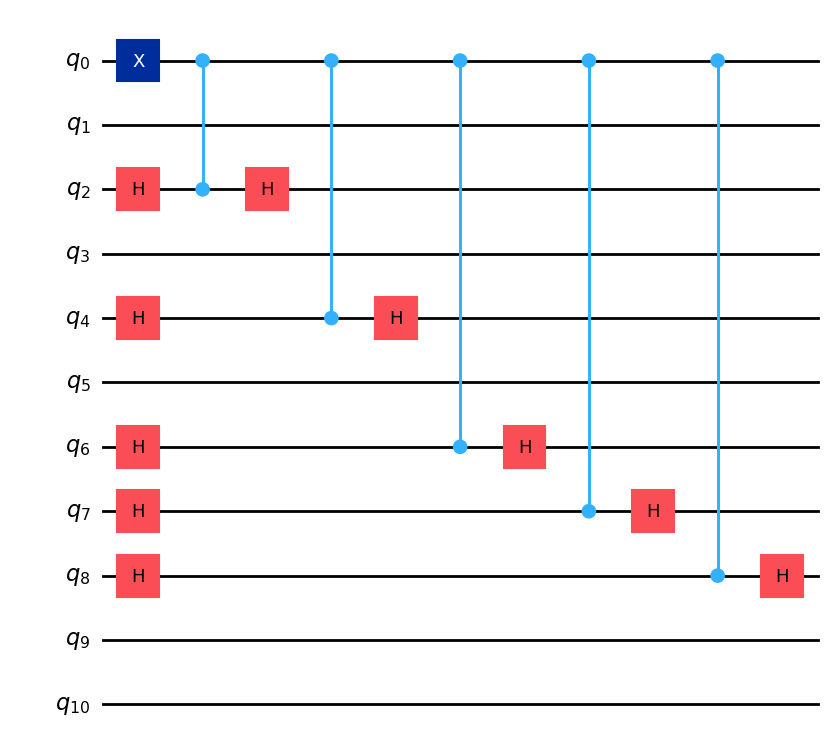

In [ ]:
# Pick your string
hidden_string = "0101011100"
num_qubits = len(hidden_string) + 1

# Ideal circuit
qc = gen_bv_circ(num_qubits, hidden_string=hidden_string)
qc.draw("mpl")

We first define our hardware specifications and use them to transpile the Qiskit circuit according to our needs.

We can choose to apply additional Dynamical Decoupling (DD) on idle qubits during Rzz gates via the `DD_during_Rzz` function.

We then define our `PulseCircuit`s to which we attach the transpiled circuit and the hardware specifications. For the noisy case, we also attach an experimental environment that specifies the noise.


In [ ]:
optim = 1  # optimization during transpilation

hardware_specs = HardwareSpecs(
    num_qubits=num_qubits,
    B_field=0.006266570686577501,
    delta=0.06266570686577502,
    J_coupling=0.0031332853432887507,
    rotation_shape=Shape.GAUSSIAN,
    ramp_duration=5,
    coeff_duration=5,
    dynamical_decoupling="full_drive",
    optim=optim,
)

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2=10000,
    TJ=5000,
    duration=1048576 * 2,
    segment_duration=1048576,
    only_idle=False,
)

# ISA circuit
isa_qc_bv = hardware_specs.gate_transpile(qc)

print("string: ", hidden_string)
print("permutation: ", isa_qc_bv.layout.final_index_layout())


# Pulse circuit with and without noise
pulse_qc_bv_noiseless = PulseCircuit.from_circuit(
    isa_qc_bv, hardware_specs, store_samples=True
)
pulse_qc_bv_noisy = PulseCircuit.from_circuit(
    isa_qc_bv, hardware_specs, exp_env=exp_env, store_samples=True
)

# print(permutation)
pulse_qc_bv_noisy_DD = DD_during_Rzz(pulse_qc_bv_noisy, hardware_specs, exp_env)

string:  0101011100
permutation:  [3, 10, 0, 6, 1, 8, 2, 5, 4, 9, 7]


We can now simulate our circuit using Matrix Product State (MPS) implementation by `qiskit_aer`. We then map the physical bitstrings obtained to the logical ones using a method from `PulseCircuit` and do statistics.

In [32]:
def my_success_probability(pulse_qc, hidden_string, n_shots=1000):
    """
    Launch a MPS simulation via an AerSimulator for n_shots and
    return the probability of finding hidden_string.
    """
    circuit = pulse_qc.to_circuit()
    circuit.measure_all()

    simulator = AerSimulator(
        method="matrix_product_state",
        matrix_product_state_max_bond_dimension=int(pow(2, 10)),
        matrix_product_state_truncation_threshold=10e-3,
    )
    simulator.set_options(mps_log_data=False)
    result = simulator.run(circuit, shots=n_shots).result()

    counts = result.get_counts()
    physical_bitstrings = list(counts.keys())
    logical_bistrings = [pulse_qc.get_logical_bitstring(b) for b in physical_bitstrings]
    ordered_counts = {
        logical_bistrings[i]: counts[physical_bitstrings[i]]
        for i in range(len(physical_bitstrings))
    }
    # qiskit is flipping the bitstrings
    flipped_counts = {k[::-1]: v for k, v in ordered_counts.items()}
    # print("Counts (reordered): ", flipped_counts)

    # The result starts with 1 from the ancilla, we remove that
    flipped_counts = {k[1:]: v for k, v in flipped_counts.items()}
    if (hidden_string) in list(flipped_counts.keys()):
        P = flipped_counts[hidden_string] / n_shots
    else:
        P = 0
    return P

We repeat the process several times for noisy circuits to obtain an average. It is done using the `averaging_over_samples` method of `PulseCircuit`.

In [42]:
print("Hidden string ", hidden_string)
print("Expected output in the counts ", "1" + hidden_string)
print(
    "P_sucess_noiseless=", my_success_probability(pulse_qc_bv_noiseless, hidden_string)
)

print(
    "P_sucess_noise=",
    pulse_qc_bv_noisy.averaging_over_samples(
        my_success_probability, exp_env, hidden_string
    ),
)

print(
    "P_sucess_noise_DD=",
    pulse_qc_bv_noisy_DD.averaging_over_samples(
        my_success_probability, exp_env, hidden_string
    ),
)

Hidden string  0101011100
Expected output in the counts  10101011100


KeyboardInterrupt: 

If the samples are stored (`store_samples=True` in the initialisation of the `PulseCircuit`), we can visualize them and compute more statistics. The statistics might be different from `averaging_over_samples` as there are calculated over all the samples stored and not only on the samples created during a single call `averaging_over_samples`. In other words, if you run twice `averaging_over_samples` with the same observable(s), the statistics will be taken over the samples of both calls.

In [43]:
# import matplotlib.pyplot as plt

# print(f"Median without DD: {pulse_qc_bv_noisy.stat_samples(np.median)}.")
# print(f"Median with DD   : {pulse_qc_bv_noisy_DD.stat_samples(np.median)}.")
# print(
#     f"Mean without DD  : {pulse_qc_bv_noisy.mean_samples()}+-{pulse_qc_bv_noisy.std_samples()}."
# )
# print(
#     f"Mean with DD     : {pulse_qc_bv_noisy_DD.mean_samples()}+-{pulse_qc_bv_noisy_DD.std_samples()}."
# )

In [44]:
# samples_without_DD = pulse_qc_bv_noisy.series_samples
# samples_with_DD = pulse_qc_bv_noisy_DD.series_samples

# print(samples_without_DD)
# print(samples_with_DD)

# bins = np.histogram(np.hstack((samples_without_DD, samples_with_DD)), bins=20)[
#     1
# ]  # Get the bin edges
# plt.hist(samples_without_DD, bins=bins, density=True, alpha=0.7, label="Without DD")
# plt.hist(samples_with_DD, bins=bins, density=True, alpha=0.7, label="With DD")
# plt.ylabel("Density")
# plt.xlabel("Success probability")
# plt.grid()
# plt.legend();